In [1]:
import os, shutil
from keras import models
from keras import layers
from keras import losses
from keras import Input
from keras import Model
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import kde
import importlib as im

# my utilities
import uq_utilities as uq
import cnn_utilities as cn

Using TensorFlow backend.


In [2]:
full_data = pd.read_csv("../data_files/training_mtbd.cblv.csv", 
                   header =None, error_bad_lines = False, index_col=0).to_numpy()

full_labels = pd.read_csv("../data_files/training_mtbd_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()
print("done")

In [4]:
# log R0 sample rate and migration rate
full_labels[:,5:12] = np.log(full_labels[:,5:12])

In [5]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]

In [6]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 5000 
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [7]:
# normalize labels
labels = full_labels[0:num_sample,5:12]
norm_train_labels, train_label_means, train_label_sd = cn.normalize(labels[(num_test + num_validation):,:])
norm_validation_labels = cn.normalize(labels[num_test:num_test + num_validation,], (train_label_means, train_label_sd))
norm_test_labels = cn.normalize(labels[:num_test,], (train_label_means, train_label_sd))


In [8]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,12], 
                                  full_labels[0:num_sample,13])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [9]:
# create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)

(187110, 499, 7) (187110, 5, 2)
(1000, 499, 7) (1000, 5, 2)
(5000, 499, 7) (5000, 5, 2)


In [10]:
## define pinball loss functions
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis=-1)

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

In [11]:
def create_model():
    input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
    w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
    w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
    #w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
    w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
    w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
    w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

    w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
    w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
    w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

    # tree + geolocation dilated
    w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
    w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
    w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
    w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

    # prior known parameters and data statistics
    input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
    priors = layers.Flatten()(input_priors_tensor)
    priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

    # concatenate all above -> deep fully connected network
    concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                                 w_global_avg,
                                                                                 w_dilated_global_avg,
                                                                                 priors])

    wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)

    lower_dense = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    lower_dense = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(lower_dense)
    lower_dense = layers.Dense(16, activation = 'relu', kernel_initializer = 'VarianceScaling')(lower_dense)
    lower_q_output = layers.Dense(7, name = "lower_output")(lower_dense)
    
    upper_dense = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
    upper_dense = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(upper_dense)  
    upper_dense = layers.Dense(16, activation = 'relu', kernel_initializer = 'VarianceScaling')(upper_dense)  
    upper_q_output = layers.Dense(7, name = "upper_output")(upper_dense)
    
    return Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = [lower_q_output, upper_q_output])
 

Train on 187110 samples, validate on 5000 samples
Epoch 1/20
187110/187110 [==============================] - 403s 2ms/step - loss: 0.0828 - lower_output_loss: 0.0532 - upper_output_loss: 0.0295 - lower_output_mae: 1.6132 - lower_output_acc: 0.2733 - lower_output_mape: 1737.3086 - upper_output_mae: 1.0391 - upper_output_acc: 0.3018 - upper_output_mape: 1011.1743 - val_loss: 0.0634 - val_lower_output_loss: 0.0374 - val_upper_output_loss: 0.0257 - val_lower_output_mae: 1.2992 - val_lower_output_acc: 0.4058 - val_lower_output_mape: 1278.8035 - val_upper_output_mae: 0.9505 - val_upper_output_acc: 0.3726 - val_upper_output_mape: 1247.6440
Epoch 2/20
187110/187110 [==============================] - 415s 2ms/step - loss: 0.0569 - lower_output_loss: 0.0328 - upper_output_loss: 0.0241 - lower_output_mae: 1.0857 - lower_output_acc: 0.4404 - lower_output_mape: 1244.7998 - upper_output_mae: 0.8635 - upper_output_acc: 0.4128 - upper_output_mape: 868.1771 - val_loss: 0.0526 - val_lower_output_loss: 

Epoch 15/20
187110/187110 [==============================] - 471s 3ms/step - loss: 0.0372 - lower_output_loss: 0.0204 - upper_output_loss: 0.0168 - lower_output_mae: 0.6898 - lower_output_acc: 0.6036 - lower_output_mape: 717.5540 - upper_output_mae: 0.5922 - upper_output_acc: 0.5731 - upper_output_mape: 571.1522 - val_loss: 0.0388 - val_lower_output_loss: 0.0212 - val_upper_output_loss: 0.0174 - val_lower_output_mae: 0.7225 - val_lower_output_acc: 0.6090 - val_lower_output_mape: 775.1650 - val_upper_output_mae: 0.5688 - val_upper_output_acc: 0.5662 - val_upper_output_mape: 749.7369
Epoch 16/20
187110/187110 [==============================] - 466s 2ms/step - loss: 0.0368 - lower_output_loss: 0.0201 - upper_output_loss: 0.0167 - lower_output_mae: 0.6830 - lower_output_acc: 0.6064 - lower_output_mape: 711.7320 - upper_output_mae: 0.5869 - upper_output_acc: 0.5741 - upper_output_mape: 564.3817 - val_loss: 0.0390 - val_lower_output_loss: 0.0215 - val_upper_output_loss: 0.0173 - val_lower_ou

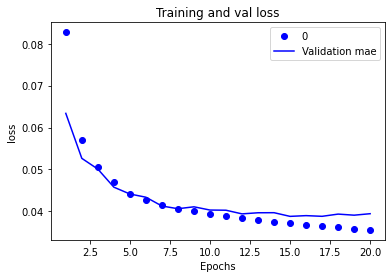

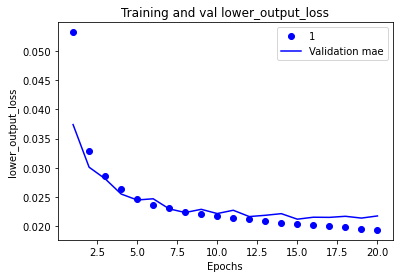

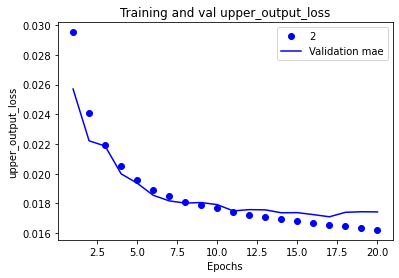

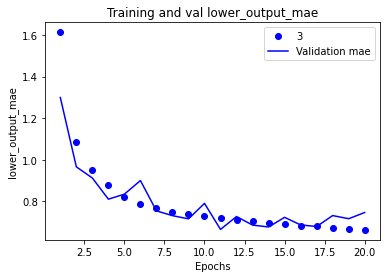

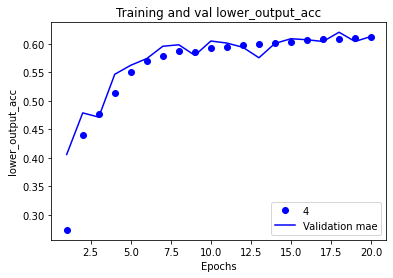

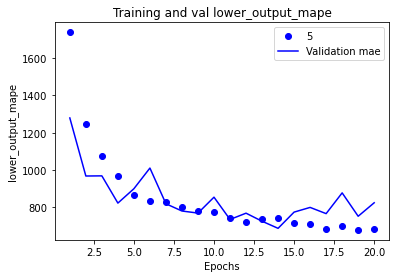

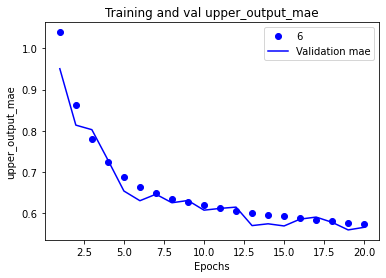

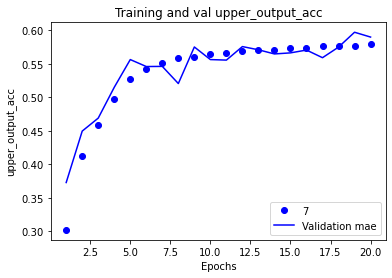

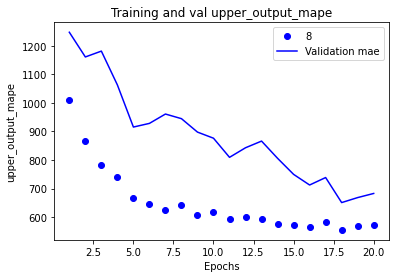

In [13]:
qq = 0.95

# instantiate MODEL
mymodel = create_model()
mymodel.compile(optimizer = 'adam', 
                loss = [pinball_loss_lower, pinball_loss_upper], 
                metrics = ['mae', 'acc', 'mape'])
history = mymodel.fit([train_treeLocation_tensor, train_prior_tensor], 
                      [norm_train_labels, norm_train_labels],
                    epochs = 20, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       [norm_validation_labels, norm_validation_labels]))


# make history plots
cn.make_history_plot(history)



In [14]:
# SAVE MODEL to FILE
import csv
all_means = np.append(train_label_means, train_aux_priors_means)
all_sd = np.append(train_label_sd, train_aux_priors_sd)
with open('trained_quantile_CNN/cqr_trained_mtbd_normalization_label_mean_sd.csv', 'w') as file:
    the_writer = csv.writer(file)
    the_writer.writerow(["mean_sd","R0_0", "R0_1", "R0_2", "R0_3", "R0_4","log_sample_rate", "log_migration_rate", 
                                "mu", "subsample_proportion", "num_tips",
                                "tmrca", "mean_bl"])
    
    the_writer.writerow(np.append("mean", all_means))
    the_writer.writerow(np.append("sd", all_sd))

mymodel.save("trained_quantile_CNN/cqr95_MTBD.hdf5")


ERROR! Session/line number was not unique in database. History logging moved to new session 4012


[[5.99405063e+00 3.96579829e+00 3.65789579e+00 4.25573701e+00
  6.28565858e+00 7.94406550e-04 4.37286683e-03]
 [2.26073694e+00 2.96458612e+00 2.31446275e+00 6.94280501e+00
  5.48175466e+00 2.87950974e-03 6.78170979e-04]]
[[8.00485722e+00 7.09123422e+00 6.81754435e+00 7.43947298e+00
  8.52588578e+00 1.19954618e-03 5.34387422e-03]
 [7.98036280e+00 7.80742304e+00 7.57221278e+00 7.92509700e+00
  8.90334360e+00 4.03479927e-03 2.08872937e-03]]


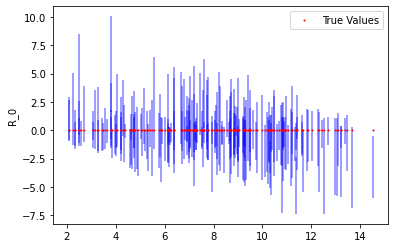

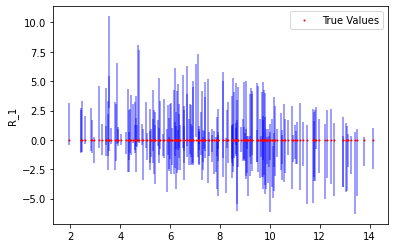

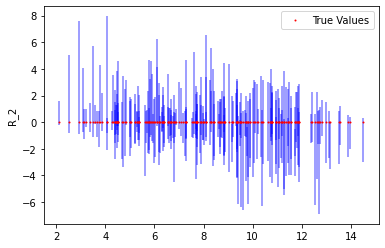

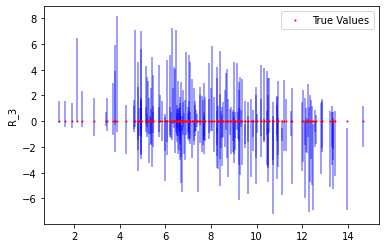

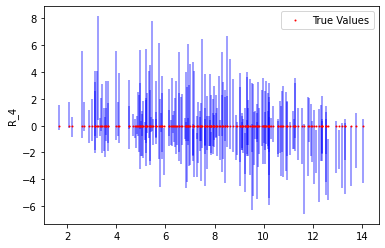

In [29]:
# test data plots

normalized_test_preds_low, normalized_test_preds_up = mymodel.predict([test_treeLocation_tensor[500:700,:,:], 
                                          test_prior_tensor[500:700,:,:]])

# reverse normalization
denormalized_test_labels = cn.denormalize(norm_test_labels[500:700,:], train_label_means, train_label_sd)
denormalized_test_labels = np.exp(denormalized_test_labels)

test_preds_low = cn.denormalize(normalized_test_preds_low, train_label_means, train_label_sd)
test_preds_low = np.exp(test_preds_low)
test_preds_up = cn.denormalize(normalized_test_preds_up, train_label_means, train_label_sd)
test_preds_up = np.exp(test_preds_up)

print(test_preds_low[0:2,:])
print(test_preds_up[0:2,:])
denormalized_test_labels[:,0:5].shape

# make scatter plots
uq.plot_QI(test_preds_low[:,0:5].T, test_preds_up[:,:5].T, denormalized_test_labels[:,0:5].T, 
                     param_names = ["R_" + str(i) for i in range(5)])